This is the source code for the plots contained in the blog post, "[Design Considerations for a Spacecraft Solar Array](https://www.osborneee.com/spacecraft-solar-array/)."

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
from collections import namedtuple

import numpy as np
from matplotlib import pyplot as plt
from solarcell import solarcell
from worstcase import unit

# Cell Parameter Definitions

In [3]:
# units, note the currents are per area: V, mA/cm2, mV/C, uA/cm2/C
celltype = namedtuple("celltype", "name voc jsc vmp jmp dvoc djsc dvmp djmp")

# define triple-junction solar cells
spectrolab = celltype("Spectrolab XTJ", 2.72, 18.0, 2.41, 17.5, -5.6, 10.0, -6.3, 5.0)
azurspace = celltype("Azur Space 3G30A", 2.69, 17.2, 2.41, 16.7, -6.2, 11.9, -6.7, 8.0)
solaero = celltype("Solaero ZTJ", 2.73, 17.4, 2.41, 16.5, -6.3, 11.7, -6.7, 9.1)

In [4]:
def si(name, nseries, nparallel, area, voc, isc, vmp, imp, dvoc, disc, dpmp):
    # function to derive silicon cell paramters from a panel datasheet

    area = area * 0.90 / (nseries * nparallel)  # account for solar panel packing factor
    jsc = isc / nparallel / area / 0.72  # short circuit current at AM0
    jmp = imp / nparallel / area / 0.72  # max power current at AM0
    voc = voc / nseries  # open circuit voltage
    vmp = vmp / nseries  # max power voltage

    dvoc = (voc * dvoc).to("mV/K")
    djsc = (jsc * disc).to("uA/cm^2/K")
    dpmp = (vmp * jmp * dpmp).to("uW/cm^2/K")
    djmp = djsc  # rough assumption
    dvmp = ((dpmp - vmp * djmp) / jmp).to("mV/K")

    dt = (28 - 25) * unit.K  # adjust to space standard test temperature
    voc = (voc + dvoc * dt).to("V")
    jsc = (jsc + djsc * dt).to("mA/cm^2")
    vmp = (vmp + dvmp * dt).to("V")
    jmp = (jmp + djmp * dt).to("mA/cm^2")

    return celltype(name, voc.m, jsc.m, vmp.m, jmp.m, dvoc.m, djsc.m, dvmp.m, djmp.m)

In [5]:
# define monocrystalline-silicon solar cells
bluebird = si(
    name="Bluebird Mono PERC",
    nseries=72,
    nparallel=1,
    area=1985 * unit.mm * 1000 * unit.mm,
    voc=50.0 * unit.V,
    isc=10.0 * unit.A,
    vmp=40.7 * unit.V,
    imp=9.70 * unit.A,
    dvoc=-0.300e-2 / unit.K,
    disc=+0.060e-2 / unit.K,
    dpmp=-0.370e-2 / unit.K,
)
solartech = si(
    name="SolarTech EPIQ Black",
    nseries=60,
    nparallel=1,
    area=997 * unit.mm * 1663 * unit.mm,
    voc=40.1 * unit.V,
    isc=9.50 * unit.A,
    vmp=33.6 * unit.V,
    imp=8.90 * unit.A,
    dvoc=-0.280e-2 / unit.K,
    disc=+0.043e-2 / unit.K,
    dpmp=-0.366e-2 / unit.K,
)
jasolar = si(
    name="JA Solar DeepBlue",
    nseries=54,
    nparallel=1,
    area=1722 * unit.mm * 1134 * unit.mm,
    voc=36.6 * unit.V,
    isc=13.4 * unit.A,
    vmp=30.3 * unit.V,
    imp=12.6 * unit.A,
    dvoc=-0.275e-2 / unit.K,
    disc=+0.045e-2 / unit.K,
    dpmp=-0.350e-2 / unit.K,
)

In [6]:
# for all cells, compute the efficiency and temperature coefficient
cells = (azurspace, solaero, spectrolab, solartech, bluebird, jasolar)
intensity = 1365  # W/m2
dT = 60  # affects results only a little

for cell in cells:
    pmp = cell.vmp * cell.jmp  # mW
    pin = intensity / 100**2
    eff = pmp / pin / 1000

    x = cell.vmp * cell.djmp  # uW/C
    y = cell.dvmp * cell.jmp  # uW/C
    z = cell.dvmp * cell.djmp * dT  # nW/C
    dpmp = (x + y + z / 1000) * 1e-3  # mW/C
    deff = dpmp / pin / 1000

    result = (cell.name, eff * 100, round(deff * 1e6, -1))
    print("{:24s} {:.1f}%    {:.0f}ppm/C".format(*result))

Azur Space 3G30A         29.5%    -700ppm/C
Solaero ZTJ              29.1%    -680ppm/C
Spectrolab XTJ           30.9%    -730ppm/C
SolarTech EPIQ Black     20.2%    -770ppm/C
Bluebird Mono PERC       22.2%    -870ppm/C
JA Solar DeepBlue        21.9%    -800ppm/C


# Curve Fitting

In [7]:
np.linspace(-16, -22, 7)

array([-16., -17., -18., -19., -20., -21., -22.])

In [8]:
def celltype2solarcell(type, area):
    return solarcell(
        isc=(type.jsc * area / 1e3, type.djsc * area / 1e6),
        voc=(type.voc, type.dvoc / 1e3),
        imp=(type.jmp * area / 1e3, type.djmp * area / 1e6),
        vmp=(type.vmp, type.dvmp / 1e3),
        t=28,
    )

Fit UB:   1.10 -16.00   0.10 1000.00   6.40 
Fit X0:   1.00 -19.00   0.10  10.00   2.40 
Fit LB:   1.00 -22.00   0.00  10.00   0.40 
Fit UB:   1.02 -18.00   0.10 175.00   3.40 
Fit X0:   1.00 -18.67   0.10  10.00   2.40 
Fit LB:   1.00 -20.00   0.08  10.00   1.40 
Fit Targets: isc=0.516, voc=2.69, imp=0.501, vmp=2.41, pmp=1.207
Fit Results: isc=0.516, voc=2.677, imp=0.5015, vmp=2.42, pmp=1.213
Fit RSS: 0.006391985581390512


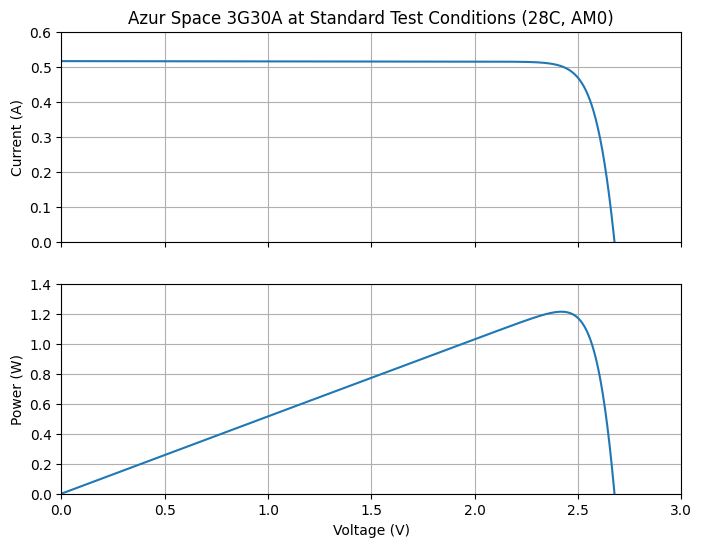

In [9]:
cell = celltype2solarcell(type=azurspace, area=30).cell(t=28, g=1)
v = np.linspace(0, cell.voc, 1000)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6))
ax[0].plot(v, cell.iv(v))
ax[1].plot(v, cell.pv(v))
ax[0].set_ylabel("Current (A)")
ax[1].set_ylabel("Power (W)")
ax[1].set_xlabel("Voltage (V)")
ax[0].grid()
ax[1].grid()
ax[0].set_xlim((0, 3))
ax[0].set_ylim((0, 0.6))
ax[1].set_ylim((0, 1.4))
ax[0].set_title("Azur Space 3G30A at Standard Test Conditions (28C, AM0)")
plt.show()

SOLVING: Spectrolab XTJ -60
Fit UB:   1.10 -16.00   0.10 1000.00   6.40 
Fit X0:   1.05 -22.00   0.00 1000.00   3.40 
Fit LB:   1.00 -22.00   0.00  10.00   0.40 
Fit UB:   1.07 -21.00   0.02 1000.00   4.40 
Fit X0:   1.05 -22.00   0.00 1000.00   3.40 
Fit LB:   1.03 -22.00   0.00 835.00   2.40 
Fit Targets: isc=6.163, voc=77.11, imp=6.142, vmp=71.15, pmp=436.9
Fit Results: isc=6.471, voc=76, imp=6.333, vmp=70.22, pmp=444.7
Fit RSS: 0.06199796779352314

SOLVING: Spectrolab XTJ 28
Fit UB:   1.10 -16.00   0.10 1000.00   6.40 
Fit X0:   1.00 -19.00   0.10  10.00   2.40 
Fit LB:   1.00 -22.00   0.00  10.00   0.40 
Fit UB:   1.02 -18.00   0.10 175.00   3.40 
Fit X0:   1.01 -18.67   0.10 175.00   2.40 
Fit LB:   1.00 -20.00   0.08  10.00   1.40 
Fit Targets: isc=6.48, voc=65.28, imp=6.3, vmp=57.84, pmp=364.4
Fit Results: isc=6.57, voc=64.27, imp=6.401, vmp=58.03, pmp=371.5
Fit RSS: 0.026508925320719766

SOLVING: Spectrolab XTJ 80
Fit UB:   1.10 -16.00   0.10 1000.00   6.40 
Fit X0:   1.08 -22

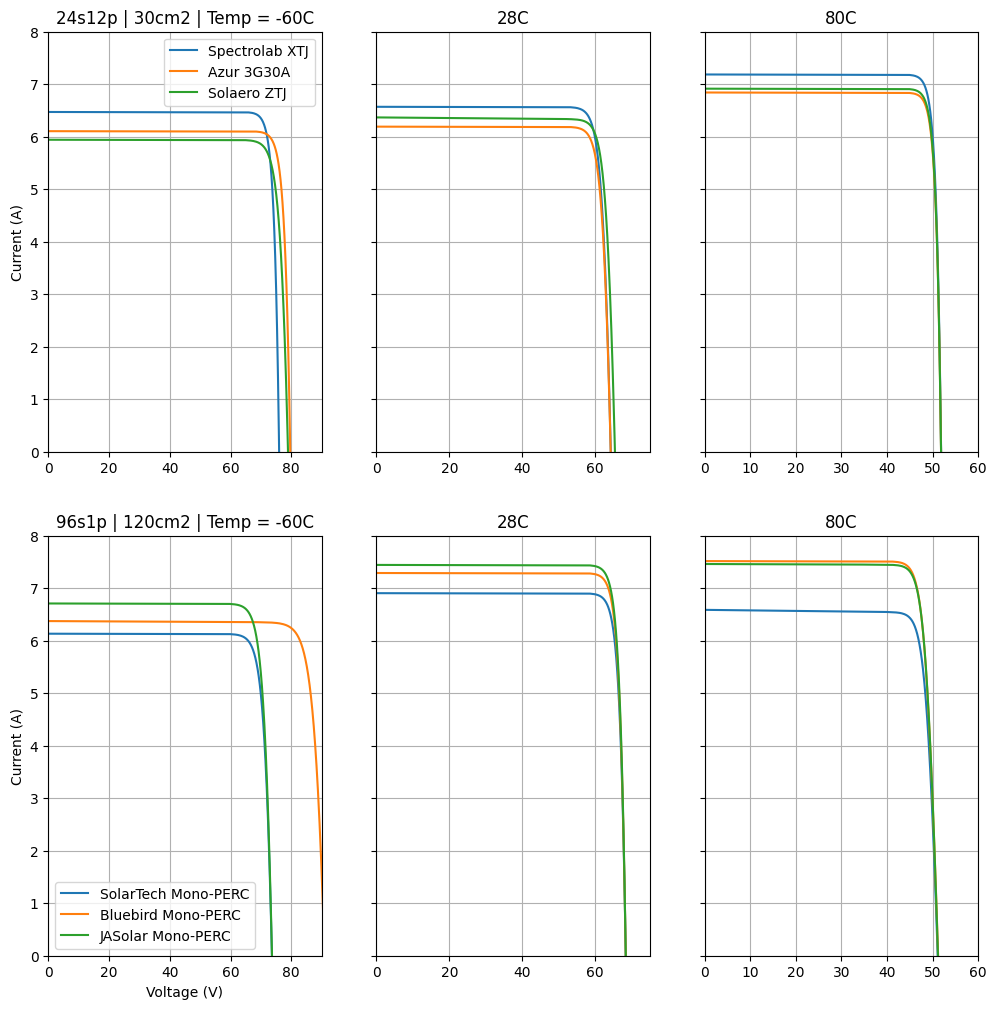

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12, 12))

for type in [spectrolab, azurspace, solaero]:
    for i, temp in enumerate([-60, 28, 80]):
        print("SOLVING:", type.name, temp)
        cell = celltype2solarcell(type, area=30).array(
            t=np.full((24, 12), temp), g=np.ones((24, 12))
        )
        v = np.linspace(0, cell.voc, 1000)
        ax[0, i].plot(v, cell.iv(v))
        print()

ax[0, 0].set_title("24s12p | 30cm2 | Temp = -60C")
ax[0, 0].set_xlim([0, 90]), ax[0, 0].grid()
ax[0, 1].set_xlim([0, 75]), ax[0, 1].grid(), ax[0, 1].set_title("28C")
ax[0, 2].set_xlim([0, 60]), ax[0, 2].grid(), ax[0, 2].set_title("80C")
ax[0, 0].legend(["Spectrolab XTJ", "Azur 3G30A", "Solaero ZTJ"])
ax[0, 0].set_ylabel("Current (A)")

for type in [solartech, bluebird, jasolar]:
    for i, temp in enumerate([-60, 28, 80]):
        print("SOLVING:", type.name, temp)
        cell = celltype2solarcell(type, area=120).array(
            t=np.full((96, 1), temp), g=np.ones((96, 1))
        )
        v = np.linspace(0, cell.voc, 1000)
        ax[1, i].plot(v, cell.iv(v))
        print()

ax[1, 0].set_title("96s1p | 120cm2 | Temp = -60C")
ax[1, 0].set_xlim([0, 90]), ax[1, 0].grid()
ax[1, 1].set_xlim([0, 75]), ax[1, 1].grid(), ax[1, 1].set_title("28C")
ax[1, 2].set_xlim([0, 60]), ax[1, 2].grid(), ax[1, 2].set_title("80C")
ax[1, 0].legend(["SolarTech Mono-PERC", "Bluebird Mono-PERC", "JASolar Mono-PERC"])
ax[1, 0].set_ylabel("Current (A)")
ax[1, 0].set_xlabel("Voltage (V)")

plt.ylim([0, 8])
plt.show()